Load Jupyter modules

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\dorasir\anaconda3\envs\net-simu\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Setup R plotting

In [2]:
%%R
# Load R libraries
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(car)
library(ggpubr)
library(rstatix)
library(xtable)
library(comprehenr)
setwd('d:\\microbial_network\\microbial_network_explore')

R[write to console]: 
载入程辑包：'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.2     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 载入需要的程辑包：carData

R[write to console]: 
载入程辑包：'car'


R[write to console]: The following object is masked from 'package:purrr':

    some


R[write to console]: The following object is masked from 'package:dplyr':

    recode


R[write to console]: 
载入程辑包：'rstatix'


R[write to console]: The following object is masked from 'package:stats':

    filter




Load Python modules

In [13]:
import numpy as np
import os
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
from utils.transformation import clr_transform, alr_transform
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from utils import simulation
import rpy2.robjects as robjects
import seaborn as sns
from utils.generalized_lotka_volterra import GeneralizedLotkaVolterra
from utils.compositional_lotka_volterra import CompositionalLotkaVolterra
from scipy.stats import ttest_rel
import utils.evaluations as ev
from utils.evaluations import correlation_score, spearman_score, precision_matrix_score, clv_score, glv_score, pcor_score, pspe_score, sparcc_score, speic_score, cclasso_score, baseline_score
from typing import List
import seaborn as sns
from utils.transformation import *

# Make sure the working directory is correct
os.chdir('d:\\microbial_network\\microbial_network_explore')

In [4]:
# Define function for evaluation
def evaluation(adj, abundance, evaluation_func, metrics=average_precision_score, verbose=False, f=None):
    scores = []
    for func in evaluation_func:
        try:
            scores.append([func._method, *func(abundance, adj, metrics=metrics, verbose=verbose)])
        except:
            scores.append([func._method, *[0] * len(metrics)])
        if f:
            f.write(f"{func._method}\n")
            f.flush()
    columns = ['Method']
    columns.extend([metric.__name__ for metric in metrics] if isinstance(metrics, List) else [metrics.__name__])
    scores_df = pd.DataFrame(scores, columns=columns)
    return scores_df

Set up the parameters for the first simulation

In [34]:
# Set up parameters
n_vertices = 20
avg_degree = 5
network_type = 'random'
interaction_type = 'random'
max_interaction_strength = 1
time_points = 500
time_step = 0.01
downsample = 1
noise_var = 1e-3

# evaluation_func = [correlation_score, spearman_score, clv_score, glv_score, pcor_score, pspe_score, sparcc_score, speic_score, baseline_score]
# evaluation_func = [correlation_score, spearman_score, pcor_score, pspe_score, sparcc_score, speic_score, baseline_score]
evaluation_func = [correlation_score, glv_score]
metrics = [average_precision_score, roc_auc_score]

normalization_methods = [clr_transform, css_transform, tmm_transform, tmmwsp_transform, rle_transform, gmpr_transform, logcpm_transform, ast_transform, blom_transform, vst_transform, npn_transform, no_transform]

In [35]:
%%capture
result_df = pd.DataFrame(columns=["Method", "run", "average_precision_score", "roc_auc_score", "Norm Method"])
repeat = 50
rng = np.random.default_rng(42)

for i in range(repeat):
    seed = rng.integers(0, 2 ** 32 - 1)
    adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type, interaction_type, max_interaction_strength=1, seed=seed)
    z, x, abd, _, _ = simulation.simulate_glv(
        time_points=time_points,
        time_step=time_step,
        downsample=1,
        noise_var=0,
        adj=adj,
        M=M,
        seed=seed,
    )
    for norm_method in normalization_methods:
        try:
            norm_abd = norm_method(abd)
            # norm_abd = norm_method(z, abd)
        except:
            norm_abd = abd
        scores_df = evaluation(adj, norm_abd, evaluation_func, metrics=metrics)
        scores_df['Norm Method'] = norm_method._method
        scores_df['run'] = i
        result_df = result_df.append(scores_df)
    result_df.to_csv('data/results/normalization.csv', index=False)

In [12]:
%%R -i result_df
result_df <- result_df %>% filter(`Method` == 'Pearson')
result_df$Norm <- with(result_df, relevel(as.factor(`Norm Method`), "None"))
methods = unique(result_df$Norm)
my_comparisons = to_list(for (method in methods) if (method != 'None') c(method, 'None'))
my_palette <- brewer.pal(n = length(methods), name = "Paired")
pr_box <- ggplot(result_df, aes(x=Norm, y=average_precision_score, color=Norm)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 1, alpha = 0.3) +
  scale_fill_brewer(palette = "Paired") +
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Normalization Method", y = "Average Precision Score") +
  # ggtitle("Absolute abundance") +
  stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 'wilcox.test', paired = TRUE, method.args = list(alternative = 'greater')) +
  theme(plot.title = element_text(hjust = 0.5))
pr_box
ggsave(filename = "figures\\box_norm_pearson_prauc.pdf",
 width = 20, height = 20, units = "cm")

# auroc_box <- ggplot(result_df, aes(x=Norm, y=roc_auc_score, color=Norm)) +
#   geom_boxplot() +
#   geom_jitter(width = 0.2, size = 1, alpha = 0.3) +
#   scale_fill_brewer(palette = "Paired") +
#   scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
#   theme_bw() +
#   theme(legend.position = "none") +
#   labs(x = "Normalization Method", y = "Average Precision Score") +
#   # ggtitle("Absolute abundance") +
#   stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 'wilcox.test', paired = TRUE, method.args = list(alternative = 'greater')) +
#   theme(plot.title = element_text(hjust = 0.5))
# box_norm <- pr_box + auroc_box
# box_norm
# ggsave(filename = "figures\\box_norm_pearson.pdf",
#  width = 40, height = 20, units = "cm")

c:\Users\dorasir\anaconda3\envs\net-simu\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [39]:
%%capture
normalization_methods = [qn_transform, fsqn_trasform, bmc_transform, limma_transform, combat_transform, no_transform]
evaluation_func = [correlation_score]
result_df = pd.DataFrame(columns=["Method", "run", "average_precision_score", "roc_auc_score", "Norm Method"])
repeat = 50
rng = np.random.default_rng(42)

for i in range(repeat):
    seed = rng.integers(0, 2 ** 32 - 1)
    adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type, interaction_type, max_interaction_strength=1, seed=seed)
    z, x, abd, _, _ = simulation.simulate_glv(
        time_points=time_points,
        time_step=time_step,
        downsample=1,
        noise_var=0,
        adj=adj,
        M=M,
        seed=seed,
    )
    for norm_method in normalization_methods:
        try:
            # norm_abd = norm_method(abd)
            norm_abd = norm_method(z, abd)
        except:
            norm_abd = abd
        scores_df = evaluation(adj, norm_abd, evaluation_func, metrics=metrics)
        scores_df['Norm Method'] = norm_method._method
        scores_df['run'] = i
        result_df = result_df.append(scores_df)

In [42]:
%%R -i result_df
result_df$Norm <- with(result_df, relevel(as.factor(`Norm Method`), "None"))
methods = unique(result_df$Norm)
my_comparisons = to_list(for (method in methods) if (method != 'None') c(method, 'None'))
my_palette <- brewer.pal(n = length(methods), name = "Paired")
pr_box <- ggplot(result_df, aes(x=Norm, y=average_precision_score, color=Norm)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 1, alpha = 0.3) +
  scale_fill_brewer(palette = "Paired") +
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Normalization Method", y = "Average Precision Score") +
  # ggtitle("Absolute abundance") +
  stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 'wilcox.test', paired = TRUE, method.args = list(alternative = 'greater')) +
  theme(plot.title = element_text(hjust = 0.5))
pr_box
ggsave(filename = "figures\\box_norm_pearson_prauc_ref.pdf",
  width = 20, height = 20, units = "cm")

c:\Users\dorasir\anaconda3\envs\net-simu\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [20]:
result_df2 = pd.read_table('data/results/normalization_no_ref.csv', sep=',')

In [21]:
result_df_all = pd.concat([result_df, result_df2])

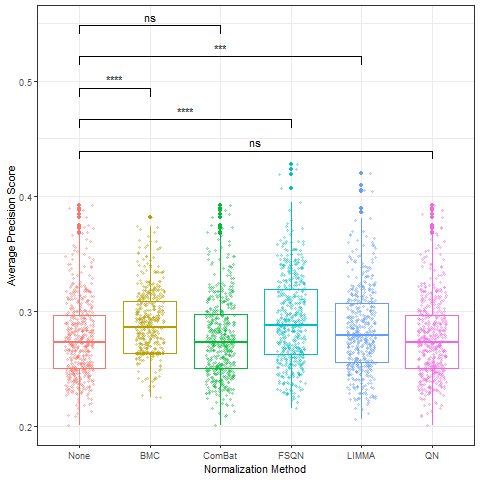

In [41]:
%%R
result_df <- read.csv('data/results/normalization_with_ref.csv')
result_df <- result_df %>% filter(`Method` == 'Pearson')
result_df$Norm <- with(result_df, relevel(as.factor(`Norm.Method`), "None"))
methods = unique(result_df$Norm)
my_comparisons = to_list(for (method in methods) if (method != 'None') c(method, 'None'))
my_palette <- brewer.pal(n = length(methods), name = "Paired")
pr_box <- ggplot(result_df, aes(x=Norm, y=average_precision_score, color=Norm)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, size = 1, alpha = 0.3) +
  scale_fill_brewer(palette = "Paired") +
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Normalization Method", y = "Average Precision Score") +
  # ggtitle("Absolute abundance") +
  stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 'wilcox.test', paired = TRUE, method.args = list(alternative = 'greater')) +
  theme(plot.title = element_text(hjust = 0.5))
pr_box

In [83]:
%%capture
result_df = pd.DataFrame(columns=["Method", "run", "average_precision_score", "roc_auc_score", "abs_rel"])
repeat = 500
rng = np.random.default_rng(42)

org = []
sampled = []
for i in range(repeat):
    seed = rng.integers(0, 2 ** 32 - 1)
    adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type, interaction_type, max_interaction_strength=1, seed=seed)
    z, x, abd, _, _ = simulation.simulate_glv(
        time_points=time_points,
        time_step=time_step,
        downsample=1,
        noise_var=0,
        adj=adj,
        M=M,
        seed=seed,
    )
    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df["run"] = i
    score_df["abs_rel"] = "org"
    result_df = result_df.append(score_df, ignore_index=True)

    score_df = evaluation(adj, z, evaluation_func, metrics=metrics, verbose=False)
    score_df["run"] = i
    score_df["abs_rel"] = "norm"
    result_df = result_df.append(score_df, ignore_index=True)

    score_df = evaluation(adj, abd, evaluation_func, metrics=metrics, verbose=False)
    score_df["run"] = i
    score_df["abs_rel"] = "resampled"
    result_df = result_df.append(score_df, ignore_index=True)
a = result_df[result_df["abs_rel"] == "org"]['average_precision_score']
b = result_df[result_df["abs_rel"] == "norm"]['average_precision_score']
c = result_df[result_df["abs_rel"] == "resampled"]['average_precision_score']

In [84]:
from scipy.stats import wilcoxon
wilcoxon(a, c, alternative='greater')
wilcoxon(b, c, alternative='greater')

WilcoxonResult(statistic=63601.0, pvalue=0.3813452218434499)

In [19]:
%%R
source('src\\normalization\\normalization.R')

In [56]:
%%R
library(metagenomeSeq)
css.func <- function(tab){
      tab_mrexperiment <- newMRexperiment(tab)
      tab_css <- cumNorm(tab_mrexperiment)
      tab_norm <- MRcounts(tab_css, norm=T)
      as.data.frame(tab_norm)
    }
css <- css.func(abd)
write.csv(css, 'data\\css.csv', row.names=FALSE)

R[write to console]: Default value being used.



In [40]:
%%R
library(edgeR)
logcpm <- cpm(abd, log=TRUE)
write.csv(logcpm, 'logcpm.csv', row.names=FALSE)

R[write to console]: 
载入程辑包：'edgeR'


R[write to console]: The following object is masked from 'package:metagenomeSeq':

    calcNormFactors




In [60]:
%%R
tmm.func <- function(tab){
      tab <- as.matrix(tab)
      tab_dge <- DGEList(counts=tab)
      tab_tmm_dge <- calcNormFactors(tab_dge, method="TMMwsp")
      tab_norm <- cpm(tab_tmm_dge)
      as.data.frame(tab_norm)
    }
tmm <- tmm.func(abd)
write.csv(tmm, 'tmm.csv', row.names=FALSE)

In [57]:
abd_combat = np.genfromtxt('combat.csv', delimiter=',', skip_header=1, usecols=range(1, abd.shape[1] + 1))
abd_css = np.genfromtxt('css.csv', delimiter=',', skip_header=1,)
abd_logcpm = np.genfromtxt('logcpm.csv', delimiter=',', skip_header=1,)

In [61]:
abd_tmm = np.genfromtxt('tmm.csv', delimiter=',', skip_header=1,)

In [43]:
abd_clr = clr_transform(abd)

In [58]:
correlation_score(abd_css.T, adj)

0.6944444444444444

In [62]:
correlation_score(abd_tmm.T, adj)

0.6116666666666666

In [48]:
correlation_score(np.arcsin(np.sqrt(abd)).T, adj)

0.5657142857142857

In [59]:
print(correlation_score(abd.T, adj))
print(correlation_score(abd_combat.T, adj))

0.46571428571428575
0.5222222222222221


In [34]:
clv_score(abd.T, adj)

0.7196063792132975


0.5029018820685488

In [39]:
print(glv_score(abd.T, adj))
# print(glv_score(abd_combat.T, adj))
print(glv_score(abd_css.T, adj))

0.4590350877192983
0.5105934343434344


In [46]:
abd.sum()

500.0

Test different normalization methods